In [1]:
from src import bootstrap, trainer, data, models
import src.preprocess.util as preprocessing_util
import pandas as pd
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns

import scipy
from sklearn.metrics import silhouette_score

import numpy as np

from umap import UMAP

/opt/homebrew/Caskroom/miniconda/base/envs/cpr/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/homebrew/Caskroom/miniconda/base/envs/cpr/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/homebrew/Caskroom/miniconda/base/envs/cpr/l

In [2]:
# Change this suffix name if you want to retrain the model, otherwise it will load the saved model
suffix = "split"

exp_name = f"MIMIC_{suffix}"

In [3]:
bs_name = "MIMIC"
feature_cols = ["temperature", "hematocrit", "potassium", "wbc", "meanbp", "heartratehigh", "creatinine"]
time_col = "ic_t"
target_col = "antibiotics_n"
identifier_col = "identifier"
dataset = "mimic"

context_size = len(feature_cols) + 2
input_size = len(feature_cols) + 1

## Load data


In [4]:
train_r, val_r, test_r = bootstrap.load_split(dataset=dataset)
train, val, test = preprocessing_util.standardize(train=train_r, val=val_r, test=test_r, feature_cols=feature_cols)

ds_train = data.Context_df_dataset(train, feature_cols=feature_cols, target_col=target_col, identifier_col=identifier_col,
                                    max_length=train.ic_t.max() + 1)
ds_val = data.Context_df_dataset(val, feature_cols=feature_cols, target_col=target_col, identifier_col=identifier_col,
                                    max_length=train.ic_t.max() + 1)
ds_test = data.Context_df_dataset(test, feature_cols=feature_cols, target_col=target_col, identifier_col=identifier_col,
                                    max_length=test.ic_t.max() + 1)

loader_train = DataLoader(ds_train, shuffle=True, batch_size=64)
loader_val = DataLoader(ds_val, shuffle=True, batch_size=64)
loader_test = DataLoader(ds_test, shuffle=False, batch_size=1)

ds_train_v = data.Vanilla_df_dataset(train, feature_cols=feature_cols, target_col=target_col, identifier_col=identifier_col, 
                                     action_col="antibiotics", max_length=train.ic_t.max() + 1)
ds_val_v = data.Vanilla_df_dataset(val, feature_cols=feature_cols, target_col=target_col, identifier_col=identifier_col, 
                                     action_col="antibiotics", max_length=train.ic_t.max() + 1)
ds_test_v = data.Vanilla_df_dataset(test, feature_cols=feature_cols, target_col=target_col, identifier_col=identifier_col, 
                                     action_col="antibiotics", max_length=train.ic_t.max() + 1)

loader_train_v = DataLoader(ds_train_v, shuffle=True, batch_size=64)
loader_val_v = DataLoader(ds_val_v, shuffle=True, batch_size=64)
loader_test_v = DataLoader(ds_test_v, shuffle=False, batch_size=1)

full_df = pd.concat([train, val, test]).reset_index(drop=True)
ds_all = data.Context_df_dataset(full_df, feature_cols=feature_cols, target_col=target_col, identifier_col=identifier_col, 
                                 max_length=full_df.ic_t.max() + 1)
loader_all = DataLoader(ds_all, shuffle=False, batch_size=1) 

## Train model 

In [5]:
for rnn_type in ["LSTM", "RNN"]:
    trainer.train_contextual(exp_name=exp_name, context_size=context_size, input_size=input_size, train_loader=loader_train, 
                            val_loader=loader_val, lr=5e-4, lambdas=[0.1, 0.01, 0.001, 0.0001])

for rnn_type in ["LSTM", "RNN"]:
    trainer.train_vanilla(exp_name=exp_name, input_size=input_size, train_loader=loader_train_v, 
                            val_loader=loader_val_v, lr=1e-4)


Run context_LSTM_16_0.1 already exists, skipping.
Run context_LSTM_16_0.01 already exists, skipping.
Run context_LSTM_16_0.001 already exists, skipping.
Run context_LSTM_16_0.0001 already exists, skipping.
Run context_LSTM_32_0.1 already exists, skipping.
Run context_LSTM_32_0.01 already exists, skipping.
Run context_LSTM_32_0.001 already exists, skipping.
Run context_LSTM_32_0.0001 already exists, skipping.
Run context_LSTM_64_0.1 already exists, skipping.
Run context_LSTM_64_0.01 already exists, skipping.
Run context_LSTM_64_0.001 already exists, skipping.
Run context_LSTM_64_0.0001 already exists, skipping.
Run context_LSTM_16_0.1 already exists, skipping.
Run context_LSTM_16_0.01 already exists, skipping.
Run context_LSTM_16_0.001 already exists, skipping.
Run context_LSTM_16_0.0001 already exists, skipping.
Run context_LSTM_32_0.1 already exists, skipping.
Run context_LSTM_32_0.01 already exists, skipping.
Run context_LSTM_32_0.001 already exists, skipping.
Run context_LSTM_32_0.0

In [6]:
trainer.evaluate_split(test_loader_c=loader_test, test_loader_v=loader_test_v, exp_name=exp_name)

context_RNN_32_0.0001 results:
AUC: 0.797, AUPRC: 0.881, Brier: 0.150

context_LSTM_32_0.0001 results:
AUC: 0.800, AUPRC: 0.882, Brier: 0.150

baseline_RNN_32 results:
AUC: 0.812, AUPRC: 0.888, Brier: 0.143

baseline_LSTM_64 results:
AUC: 0.815, AUPRC: 0.892, Brier: 0.142



In [7]:
# load best model 
best_context_l = trainer.get_best_run(exp=exp_name, pref="context_LSTM")


In [8]:
compare_RNN=False
# None uses the best model, otherwise use the penalty specified
set_penalty = None

suffix=""

if compare_RNN:
    best_context_l = best_context_l.replace("context_LSTM", "context_RNN")
    suffix+="RNN"

if set_penalty is not None:
    best_context_l = "_".join(best_context_l.split("_")[:-1]) + f"_{set_penalty}"
    suffix+=f"_{set_penalty}"

model_c =  trainer.load_run(run=best_context_l, dataset_name=exp_name)

In [ ]:
pred, true = models.model_predict(model=model_c, loader=loader_test)
auroc, auprc, brier, _ = trainer.calculate_results(pred, true)
print(f"AUC: {auroc:.3f}, AUPRC: {auprc:.3f}, Brier: {brier:.3f}")

(0.7997423695842208,
 0.8821414363888165,
 0.14961902157515833,
 0.8676122931442078)

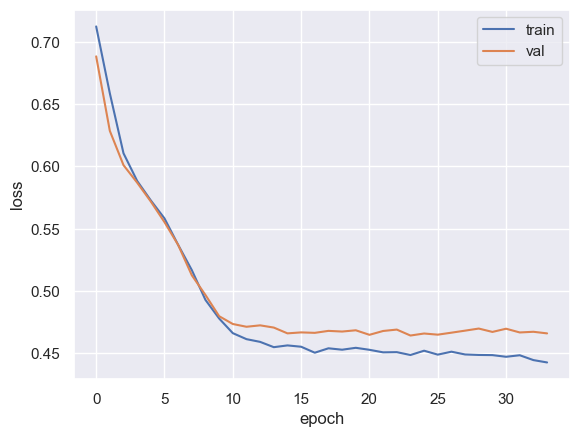

In [ ]:
sns.set()
fig, ax = plt.subplots()
trainer.plot_run(exp=exp_name, run=best_context_l, ax=ax)
plt.savefig("../figures/ADNI_c_loss.pdf", bbox_inches="tight")

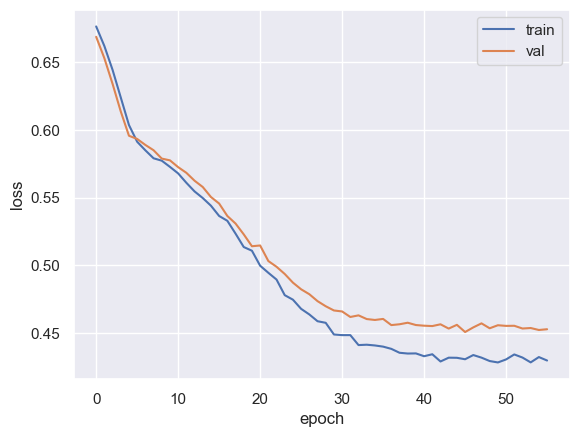

In [ ]:
sns.set()
fig, ax = plt.subplots()
trainer.plot_run(exp=exp_name, run="baseline_LSTM_64", ax=ax)
plt.savefig("../figures/ADNI_b_loss.pdf", bbox_inches="tight")



bs_name = "MIMIC"
feature_cols = ["temperature", "hematocrit", "potassium", "wbc", "meanbp", "heartratehigh", "creatinine"]
time_col = "ic_t"
target_col = "antibiotics_n"
identifier_col = "identifier"
dataset = "mimic"

best_context_l = bootstrap.get_best_model(experiment_name=bs_name, pref="context_LSTM")
best_context_l = trainer.get_best_run(exp="mimic_split", pref="context_LSTM")

# Look at RNN with same Hyperparamter combination


model =  trainer.load_run(run=best_context_l, dataset_name="MIMIC_split")

## Analyze Coefficients

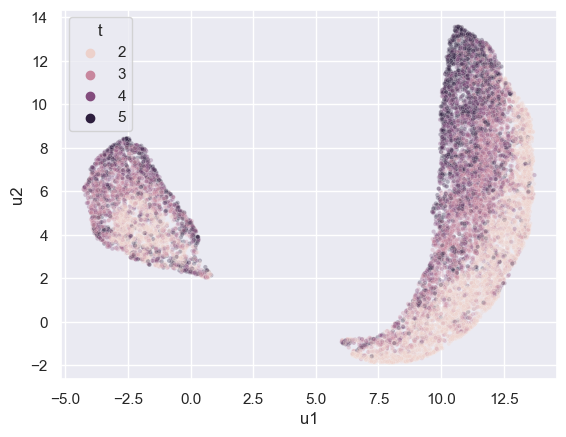

In [12]:
coef_df, enc = models.map_to_2d(model = model_c, loader_test=loader_all, feature_cols=feature_cols, drop_first=True)

fig, ax = plt.subplots()
plot_df = coef_df.copy()
plot_df["t"] = plot_df["t"] + 1
ax = sns.scatterplot(data=plot_df, x="u1", y="u2", hue="t", alpha=0.3, legend=True, s=10)
ax.set_xlabel("u1")
ax.set_ylabel("u2")
fig.savefig(f"../figures/MIMIC_cluster_noinit_{suffix}.pdf", bbox_inches='tight' )

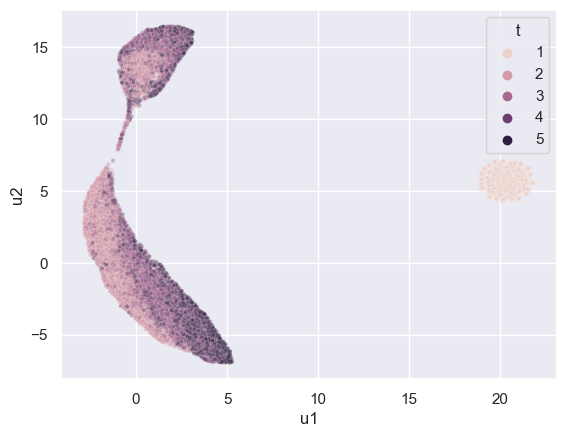

In [15]:
coef_df, enc = models.map_to_2d(model = model_c, loader_test=loader_all, feature_cols=feature_cols, drop_first=False)

fig, ax = plt.subplots()
plot_df = coef_df.copy()
plot_df["t"] = plot_df["t"] + 1
ax = sns.scatterplot(data=plot_df, x="u1", y="u2", hue="t", alpha=0.3, legend=True, s=10)
ax.set_xlabel("u1")
ax.set_ylabel("u2")
fig.savefig(f"../figures/MIMIC_cluster_{suffix}.pdf", bbox_inches='tight' )

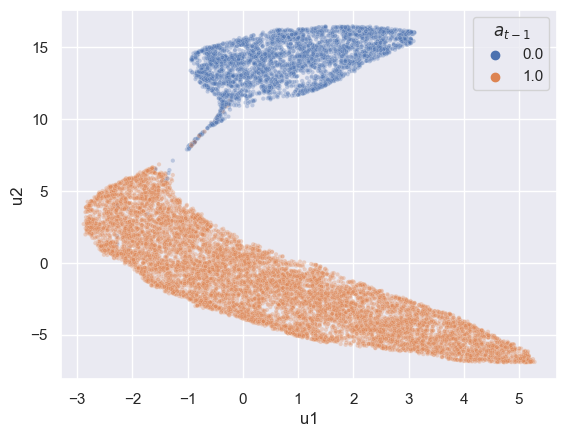

In [16]:
merge = full_df[["identifier", "antibiotics", "ic_t"]].copy()
merge.rename(columns={"identifier": "id", "antibiotics": r"$a_{t-1}$", "ic_t":"t"}, inplace=True)

try:
    df = pd.merge(coef_df, merge, on=["id", "t"])
except ValueError:
    coef_df.id = coef_df.id.astype(str)
    df = pd.merge(coef_df, merge, on=["id", "t"])
df = df[df.t > 0]
fig, ax = plt.subplots()
sns.scatterplot(data=df, x="u1", y="u2", hue=r"$a_{t-1}$", alpha=0.3, legend=True, s=10, ax=ax)

fig.savefig(f"../figures/MIMIC_cluster_antibiotics_p_{suffix}.pdf", bbox_inches='tight' )

## Condition on previous actions

/opt/homebrew/Caskroom/miniconda/base/envs/cpr/lib/python3.9/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/var/folders/gh/d90ndmrs5cnbgp4smtcmckjc0000gn/T/ipykernel_40387/3782032425.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  samples["alpha"] = 0.12
/var/folders/gh/d90ndmrs5cnbgp4smtcmckjc0000gn/T/ipykernel_40387/3782032425.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

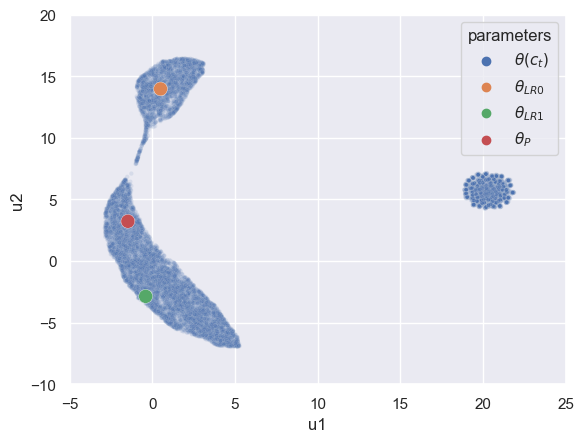

In [17]:
## Condition on previous actions
x_train = train[feature_cols].values
y_train = train["antibiotics_n"].values

x_val = val[feature_cols].values
y_val = val["antibiotics_n"].values

x_test = test[feature_cols].values
y_test = test["antibiotics_n"].values

base = trainer.fit_lr(x_train=x_train, y_train=y_train, x_val=x_val, y_val=y_val)

train_t1 = train[train.ic_t>=1]
val_t1 = val[val.ic_t>=1]
test_t1 = test[test.ic_t>=1]

train_prev1 = train_t1[train_t1.antibiotics==1]
train_prev0 = train_t1[train_t1.antibiotics==0]

val_prev1 = val_t1[val_t1.antibiotics==1]
val_prev0 = val_t1[val_t1.antibiotics==0]

test_prev1 = test_t1[test_t1.antibiotics==1]
test_prev0 = test_t1[test_t1.antibiotics==0]

lr_0 = trainer.fit_lr(x_train=train_prev0[feature_cols].values, y_train=train_prev0["antibiotics_n"].values,
                     x_val=val_prev0[feature_cols].values, y_val=val_prev0["antibiotics_n"].values)
lr_1 = trainer.fit_lr(x_train=train_prev1[feature_cols].values, y_train=train_prev1["antibiotics_n"].values,
                     x_val=val_prev1[feature_cols].values, y_val=val_prev1["antibiotics_n"].values)

coef_0 = np.hstack((lr_0.coef_[0], lr_0.intercept_[0]))
coef_1 = np.hstack((lr_1.coef_[0], lr_1.intercept_[0]))
coef_all = np.hstack((base.coef_[0], base.intercept_[0]))

umap_1 = enc.transform(coef_1.reshape(1,-1))
umap_0 = enc.transform(coef_0.reshape(1,-1))
umap_all = enc.transform(coef_all.reshape(1,-1))

samples = coef_df[["u1", "u2"]]
samples["alpha"] = 0.12
samples["parameters"] = r"$\theta(c_t)$"
samples["s"] = 10
samples["color"] = "grey"

df_0 = pd.DataFrame({"u1": umap_0[0,0], "u2": umap_0[0,1], "alpha":[1], "parameters":[r"$\theta_{LR0}$"], "s":[100], "color":"red"}, 
                    index=[0])
df_1 = pd.DataFrame({"u1": umap_1[0,0], "u2": umap_1[0,1], "alpha":[1], "parameters":[r"$\theta_{LR1}$"], "s":100, "color":"blue"}, 
                    index=[0])
df_all = pd.DataFrame({"u1": umap_all[0,0], "u2": umap_all[0,1], "alpha":[1], "parameters":[r"$\theta_{P}$"], "s":100, "color":"green"}, 
                    index=[0])

df_combined = pd.concat((samples, df_0, df_1, df_all))
fig, ax = plt.subplots()

sns.scatterplot(data=df_combined, x="u1", y="u2", alpha=df_combined.alpha, legend=True, hue=df_combined.parameters, s=df_combined.s, ax=ax)
ax.set_xlim(-5, 25)
ax.set_ylim(-10, 20)

fig.savefig("../figures/MIMIC_cluster_lr.pdf", bbox_inches='tight' )

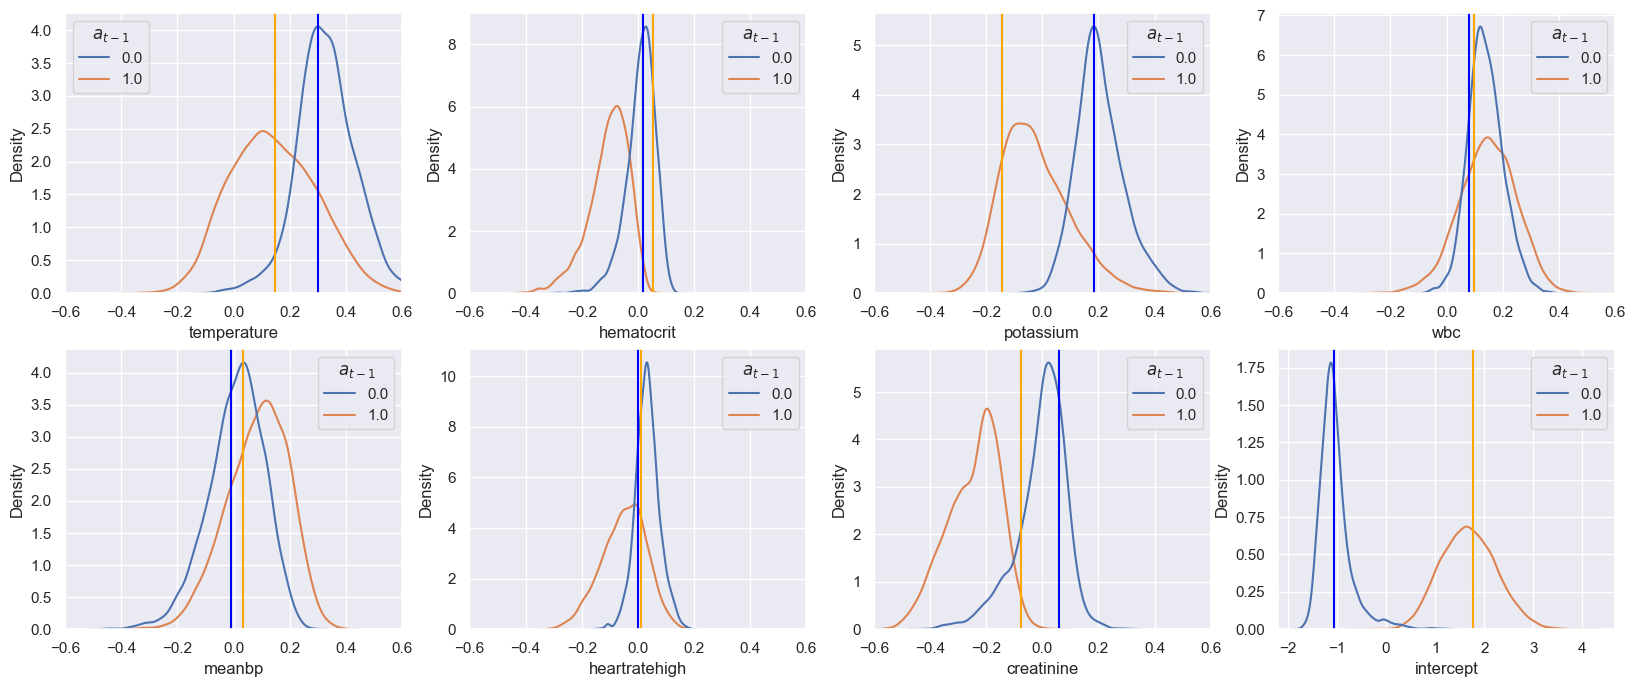

In [22]:
sns.set()

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(20,8))

coefs = feature_cols + ["intercept"]

for coef in coefs:
    col = coefs.index(coef) % 4
    row = coefs.index(coef) // 4

    axi = ax[row, col]

    df_p = df

    sns.kdeplot(df_p, x=coef, ax=axi, hue="$a_{t-1}$", legend=True, common_norm=False)
    axi.axvline(x=coef_0[coefs.index(coef)], color="blue")
    axi.axvline(x=coef_1[coefs.index(coef)], color="orange")

    if coef != "intercept":
        axi.set_xlim(-0.6, 0.6)

fig.savefig(f"../figures/MIMIC_cluster_antibiotics_p_kde_{suffix}.pdf", bbox_inches='tight')

## Condition on previous actions

## Compare population model against contextualized model 

In [66]:
def plot_pop_vs_context(t, reducer, coef_df, pop_models, ax=None, t_col="t", s_context=10):
    pop_reduced = reducer.transform(pop_models[t].reshape(1,-1))
    t_df = pd.DataFrame({"u1": [pop_reduced[0,0]], "u2": [pop_reduced[0,1]], "s":[100], "alpha":[1], "legend":["population"], "hue":["r"]})
    t_context = coef_df[coef_df[t_col]==t].copy()[["u1", "u2"]]
    t_context["s"] = s_context
    t_context["alpha"] = 0.2
    t_context["legend"] = "context"
    t_context["hue"] = "b"
    t_df = pd.concat((t_df, t_context))

    if ax is None:
        fig, ax = plt.subplots()
    else:
        sns.scatterplot(data=t_df, x="u1", y="u2", alpha=t_df.alpha, legend=True, s=t_df.s, hue="legend", ax=ax)
        ax.scatter(pop_reduced[0,0], pop_reduced[0,1], s=100, c="b")
        ax.set_title(f"t={t+1}")
        ax.legend(loc="lower left")

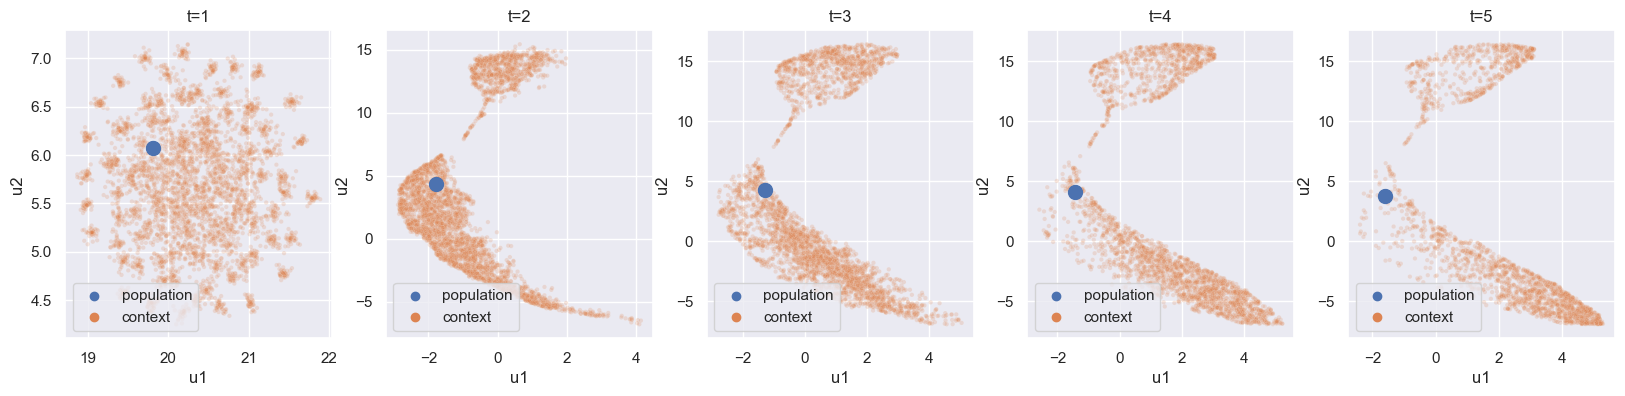

In [67]:
pop_models = {}


for t in range(5):
    train_lr_t = train[train.ic_t==t]
    x_train = train_lr_t[feature_cols].values
    y_train = train_lr_t["antibiotics_n"].values

    val_lr_t = val[val.ic_t==t]
    x_val = val_lr_t[feature_cols].values
    y_val = val_lr_t["antibiotics_n"].values

    lr_pop = trainer.fit_lr(x_train=x_train, y_train=y_train, x_val=x_val, y_val=y_val)

    coef = lr_pop.coef_[0]
    intercept = lr_pop.intercept_[0]
    
    pop_models[t] = np.hstack((coef, intercept))

fig, ax = plt.subplots(1,5, figsize=(20,4))

for i in range(5):
    plot_pop_vs_context(reducer=enc, coef_df=coef_df, t=i, pop_models=pop_models, ax=ax[i])

fig.savefig("../figures/MIMIC_pop_vs_context_time.pdf", bbox_inches="tight")

## Look at sequences

In [68]:
# Only keep patients with 4 visits
coef_df_ids = coef_df[coef_df["t"] == 3].id.unique()
coef_df = coef_df[coef_df["id"].isin(coef_df_ids)]
coef_df = coef_df[coef_df["t"] <= 3]

def create_coef_sequence(df, feature_cols=feature_cols):
    a = df.pivot(index='id', columns="t", values=feature_cols + ["intercept"])
    a.columns = ['_'.join([str(c) for c in col]) for col in a.columns.values]

    return a

In [69]:
id_group = coef_df.groupby("id").apply(lambda x: create_coef_sequence(x, feature_cols=feature_cols))

In [70]:
method = 'ward'
criterion = 'maxclust'
dist_array = scipy.spatial.distance.pdist(id_group.values)
Z = scipy.cluster.hierarchy.linkage(dist_array, method=method)
score = -1

for n_clusters in range(2, 10):
    subtypes = scipy.cluster.hierarchy.fcluster(Z, n_clusters, criterion=criterion)
    new_score = silhouette_score(scipy.spatial.distance.squareform(dist_array), metric='precomputed', labels=subtypes)
    print(n_clusters, new_score)
    if new_score > score:
        score = new_score
        k = n_clusters

2 0.5191843131931199
3 0.49855455507086444
4 0.5430692472907791
5 0.5661310627760853
6 0.5557821460597391
7 0.388032868568641
8 0.4065398333362294
9 0.3522388685817746


In [71]:
clusters = scipy.cluster.hierarchy.fcluster(Z, k, criterion=criterion)
enco = UMAP().fit_transform(id_group.values)
embedded_sequences = pd.DataFrame.from_dict({"id": id_group.index.get_level_values(0), "u1": enco[:,0], "u2": enco[:,1], "cluster": clusters})

In [72]:
embedded_sequences.groupby("cluster").count()

,id,u1,u2
cluster,,,
1,1707,1707,1707
2,375,375,375
3,232,232,232
4,240,240,240
5,384,384,384


In [73]:
an = embedded_sequences[embedded_sequences["cluster"].isin([1,5])]
ids = embedded_sequences.id.unique()
sample = coef_df[coef_df.id.isin(ids)]
sample = pd.merge(sample, an, on="id")

cluster_to_description = {1: "Antibiotics", 5: "No antibiotics"}
sample.cluster = sample.cluster.map(cluster_to_description)

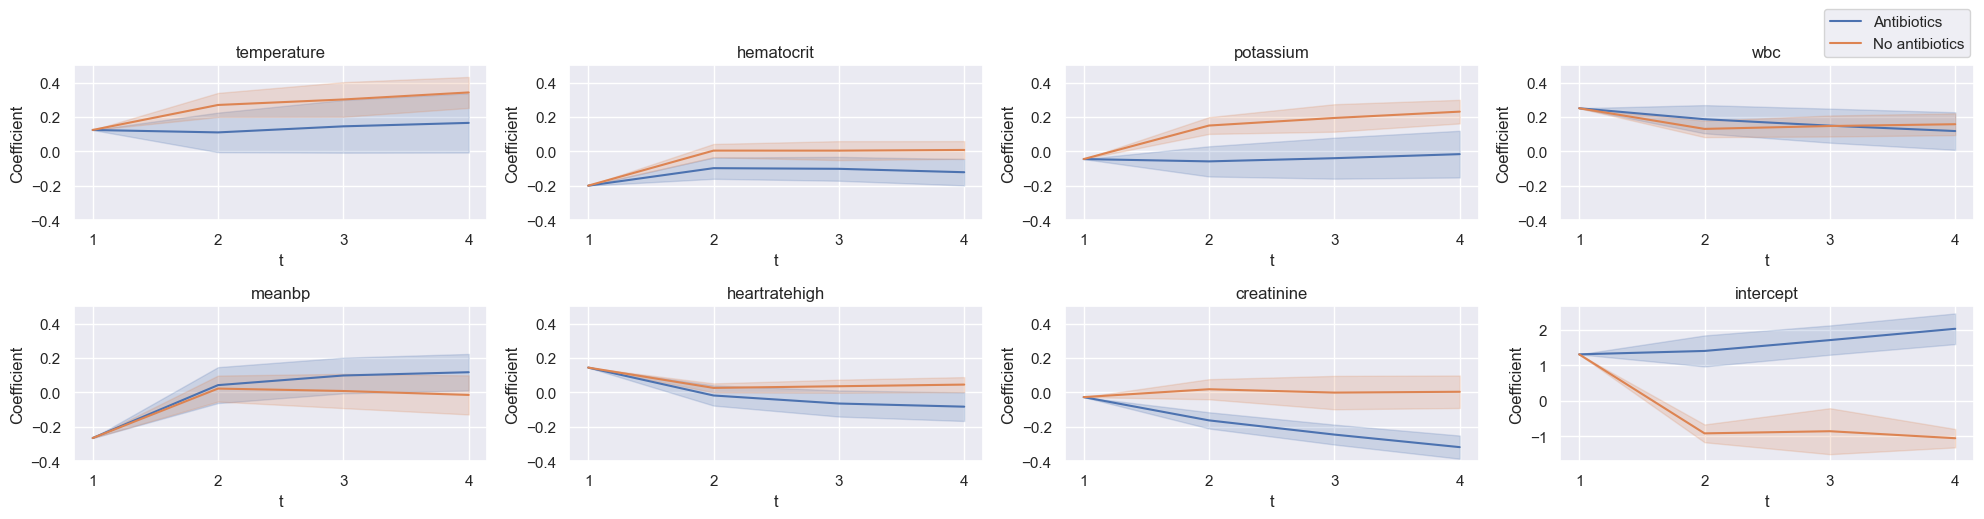

In [74]:
sns.set()
fig, ax = plt.subplots(ncols=4, nrows=2, figsize=(20, 5))


for i, feat in enumerate(["temperature", "hematocrit", "potassium", "wbc", "meanbp", "heartratehigh", "creatinine"] + ["intercept"]):
    row = i // 4
    col = i % 4
    ax_i = ax[row, col]

    sns.lineplot(data=sample, x="t", y=feat, ax=ax_i, hue="cluster", errorbar="sd").set(title=f"{feat}")
    ax_i.set_ylabel("Coefficient")
    ax_i.set_xticks(range(4), labels=[1,2,3,4])

    if feat != "intercept":
        ax_i.set_ylim([-0.4, 0.5])
    
    if feat == "intercept":

        handles, labels = ax_i.get_legend_handles_labels()
    
    ax_i.get_legend().remove()

fig.tight_layout()
fig.legend(handles, labels, loc="upper right", bbox_to_anchor=(0.993,1.051))

fig.savefig("../figures/MIMIC_antibio_vs_none.pdf", bbox_inches="tight")

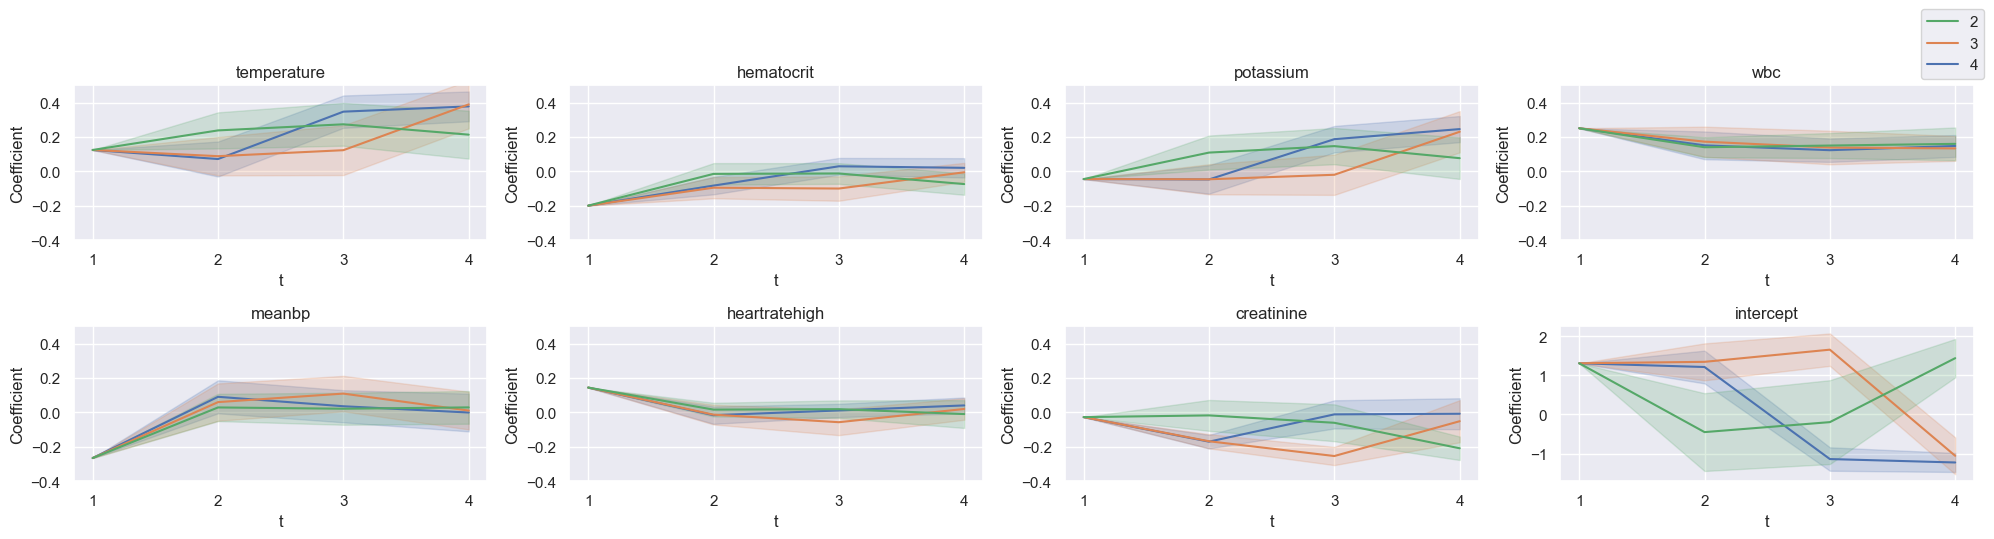

In [75]:
an = embedded_sequences[embedded_sequences["cluster"].isin([2,3,4])]
ids = embedded_sequences.id.unique()
sample = coef_df[coef_df.id.isin(ids)]
sample = pd.merge(sample, an, on="id")

cluster_to_description = {2: "2", 3: "3", 4: "4"}
sample.cluster = sample.cluster.map(cluster_to_description)


fig, ax = plt.subplots(ncols=4, nrows=2, figsize=(20, 5))
sns.set()

for i, feat in enumerate(["temperature", "hematocrit", "potassium", "wbc", "meanbp", "heartratehigh", "creatinine"] + ["intercept"]):
    row = i // 4
    col = i % 4
    ax_i = ax[row, col]

    sns.lineplot(data=sample, x="t", y=feat, ax=ax_i, hue="cluster", errorbar="sd").set(title=f"{feat}")
    ax_i.set_ylabel("Coefficient")
    ax_i.set_xticks(range(4), labels=[1,2,3,4])

    if feat != "intercept":
        ax_i.set_ylim([-0.4, 0.5])
    
    if feat == "intercept":

        handles, labels = ax_i.get_legend_handles_labels()
    
    ax_i.get_legend().remove()

fig.tight_layout()
handles, labels = plt.gca().get_legend_handles_labels()
order = [2,1,0]
fig.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc="upper right", bbox_to_anchor=(1.0,1.091))

fig.savefig("../figures/MIMIC_groups_rest.pdf", bbox_inches="tight")